## Problem Statement
Cybersecurity preparedness is a critical concern in modern digital infrastructure. This capstone project aims to predict whether an organization exhibits high or low cybersecurity readiness based on several operational factors, such as IT budget, staff training, audit frequency, and personnel perceptions like self-efficacy.

A **Random Forest Classifier** is used to model the binary outcome (`readiness_level`), followed by an interpretability phase using **SHAP (SHapley Additive Explanations)** to understand feature contributions## Objectivestives
- Preprocess and analyze a synthetic cybersecurity dataset
- Train and tune a Random Forest model
- Interpret model performance using confusion matrices
- Explain feature impacts using SHAP values
- Provide actionable insights for strategic resource allocation in cyb

## Technologies and Libraries
- **Python**, **Pandas**, **NumPy**
- **Scikit-learn** for model development
- **SHAP** for explainability
- **Matplotlib** and **Seaborn** for data visualization

This notebook represents a culmination of machine learning and data analytics techniques to guide strategic decisions in the high-stakes arena of cybersecurity operations.ersecurity

In [1]:
# Cell 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!pip install openpyxl

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import warnings
warnings.filterwarnings("ignore")

In [1]:
# Cell 2

import pandas as pd

# File names (make sure they match exactly what’s in your JupyterLab sidebar)
morning_file = "Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
afternoon_file = "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"

# Read small samples first to align schemas
morning_head = pd.read_csv(morning_file, nrows=5)
afternoon_head = pd.read_csv(afternoon_file, nrows=5)

# Union of all columns
all_cols = sorted(set(morning_head.columns).union(set(afternoon_head.columns)))

# Read full datasets, aligned on the same columns
morning = pd.read_csv(morning_file).reindex(columns=all_cols)
afternoon = pd.read_csv(afternoon_file).reindex(columns=all_cols)

# Concatenate them together
combined = pd.concat([morning, afternoon], ignore_index=True)

# Clean up column names (remove leading/trailing spaces)
combined.columns = [c.strip() for c in combined.columns]

# Optional: fix funky characters in labels (like � → -)
if "Label" in combined.columns:
    combined["Label"] = combined["Label"].str.replace("�", "-", regex=False)

# Save to new file
combined_file = "Thursday_combined_Morning_Afternoon.csv"
combined.to_csv(combined_file, index=False)

print("✅ Combined dataset saved as:", combined_file)
print("Shape:", combined.shape)
print("Label distribution:\n", combined["Label"].value_counts())


✅ Combined dataset saved as: Thursday_combined_Morning_Afternoon.csv
Shape: (458968, 79)
Label distribution:
 Label
BENIGN                        456752
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Name: count, dtype: int64


In [3]:
# Cell 3

df = pd.read_csv("Thursday_combined_Morning_Afternoon.csv")

In [22]:
# Cell 4

# === CICIDS2017 preprocessing (drop unstable rate columns, clean, split, scale) ===
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

target = "Label"

# 1) Drop problematic rate columns if present (cause inf when duration==0)
rate_cols = ["Flow Bytes/s", "Flow Packets/s"]
drop_now = [c for c in rate_cols if c in df.columns]
if drop_now:
    print("Dropping unstable columns:", drop_now)
    df = df.drop(columns=drop_now)

# 2) Split features/target
X_raw = df.drop(columns=[target]).copy()
y = df[target].copy()

# 3) Keep numeric features only (coerce strings to NaN)
X = X_raw.apply(pd.to_numeric, errors="coerce")

# 4) Replace ±inf -> NaN, drop all-NaN columns
X.replace([np.inf, -np.inf], np.nan, inplace=True)
all_nan_cols = X.columns[X.isna().all()]
if len(all_nan_cols):
    print("Dropping all-NaN columns:", list(all_nan_cols))
    X.drop(columns=list(all_nan_cols), inplace=True)

# 5) Winsorize (cap extreme values) to avoid overflow/outlier effects
q_low  = X.quantile(0.001, numeric_only=True)
q_high = X.quantile(0.999, numeric_only=True)
X = X.clip(lower=q_low, upper=q_high, axis=1)

# 6) Median impute, robust scale
imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imp)

# 7) Final sanity check and split
assert np.isfinite(X_scaled).all(), "Non-finite values remain after cleaning."

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Preprocessing complete")
print("Train:", X_train.shape, " Test:", X_test.shape)


Dropping unstable columns: ['Flow Bytes/s', 'Flow Packets/s']
✅ Preprocessing complete
Train: (321277, 76)  Test: (137691, 76)


In [24]:
# Cell 5

df.head()

,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,Bwd Packet Length Max,FIN Flag Count,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
0,1,1629110,379,5.758373e+05,278.930556,417.166667,201.416667,0,0,768,...,923,0,0,113000000,1,0.424420,13800000.0,571,48,9668
1,1,1424245,325,5.034269e+05,226.712963,317.950000,167.117647,0,0,1280,...,1139,0,0,113000000,1,0.599258,13800000.0,390,68,11364
2,0,20400000,6,1.170000e+07,0.000000,0.000000,0.000000,0,0,0,...,0,0,0,120000000,0,1.250568,24400000.0,-1,150,0
3,0,0,0,0.000000e+00,409.437500,603.000000,258.888889,0,0,152,...,1460,0,0,60300000,0,0.149348,0.0,8192,9,2330
4,0,0,0,0.000000e+00,118.750000,161.000000,51.000000,0,0,64,...,161,0,0,4,0,7434.944238,0.0,-1,2,102


In [25]:
# Cell 6

df.info()
df.describe(include='all')
df.sample(5, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 458968 entries, 0 to 458967
Data columns (total 77 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   ACK Flag Count               458968 non-null  int64  
 1   Active Max                   458968 non-null  int64  
 2   Active Min                   458968 non-null  int64  
 3   Active Std                   458968 non-null  float64
 4   Average Packet Size          458968 non-null  float64
 5   Avg Bwd Segment Size         458968 non-null  float64
 6   Avg Fwd Segment Size         458968 non-null  float64
 7   Bwd Avg Bytes/Bulk           458968 non-null  int64  
 8   Bwd Avg Packets/Bulk         458968 non-null  int64  
 9   Bwd Header Length            458968 non-null  int64  
 10  Bwd IAT Max                  458968 non-null  int64  
 11  Bwd IAT Mean                 458968 non-null  float64
 12  Bwd IAT Min                  458968 non-null  int64  
 13 

,ACK Flag Count,Active Max,Active Min,Active Std,Average Packet Size,Avg Bwd Segment Size,Avg Fwd Segment Size,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Header Length,...,Bwd Packet Length Max,FIN Flag Count,Fwd Avg Bytes/Bulk,Fwd IAT Total,Fwd PSH Flags,Fwd Packets/s,Idle Mean,Init_Win_bytes_forward,Subflow Fwd Packets,Total Length of Fwd Packets
58682,0,0,0,0.000000,102.5,142.000,42.000,0,0,40,...,142,0,0,3,0,64.718636,0.0,-1,2,84
236512,0,0,0,0.000000,93.5,105.000,41.000,0,0,20,...,105,0,0,0,0,42.245786,0.0,-1,1,41
151943,0,32869,14938,8931.583174,165.5,270.125,60.875,0,0,220,...,2149,0,0,40100000,0,0.173770,10000000.0,8192,8,487
399210,1,0,0,0.000000,7.5,6.000,6.000,0,0,60,...,6,0,0,0,0,14705.882350,0.0,254,1,6
140034,1,0,0,0.000000,9.0,0.000,6.000,0,0,0,...,0,0,0,213,0,9389.671362,0.0,5405,2,12


In [26]:
# Cell 7

df['Label'].value_counts()

Label
BENIGN                        456752
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Name: count, dtype: int64

In [27]:
# Cell 8

df.isnull().sum()

ACK Flag Count                 0
Active Max                     0
Active Min                     0
Active Std                     0
Average Packet Size            0
                              ..
Fwd Packets/s                  0
Idle Mean                      0
Init_Win_bytes_forward         0
Subflow Fwd Packets            0
Total Length of Fwd Packets    0
Length: 77, dtype: int64

In [ ]:
# Cell 9

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

xgb = XGBClassifier(
    n_estimators=400, max_depth=6, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    tree_method="hist", n_jobs=-1, random_state=42
)
xgb.fit(X_train, y_train)
print("=== XGBoost ===")
print(classification_report(y_test, xgb.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(
    xgb, X_test, y_test, cmap="Blues", normalize="true"
)


In [28]:
# Cell 10

target = "Label"
X = df.drop(columns=[target])
y = df[target]

In [29]:
# Cell 11

# Define features and target for CICIDS2017
target = "Label"
X = df.drop(columns=[target])
y = df[target]

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())


Features shape: (458968, 76)
Target distribution:
 Label
BENIGN                        456752
Web Attack - Brute Force        1507
Web Attack - XSS                 652
Infiltration                      36
Web Attack - Sql Injection        21
Name: count, dtype: int64


In [30]:
# Cell 12

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler  # sturdier than StandardScaler with outliers

# ---- 1) Split target vs features
target = "Label"
X = df.drop(columns=[target]).copy()
y = df[target].copy()

# ---- 2) Drop non-predictive ID-ish columns if present
for col in ["Flow ID", "Src IP", "Dst IP", "Timestamp", "id"]:
    if col in X.columns:
        X.drop(columns=[col], inplace=True)

# ---- 3) Keep only numeric columns (coerce anything that looks numeric)
for c in X.columns:
    if not np.issubdtype(X[c].dtype, np.number):
        X[c] = pd.to_numeric(X[c], errors="coerce")

# ---- 4) Replace inf/-inf with NaN, then impute
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Optional: cap extreme values to reduce overflow / outlier impact
# (caps at 0.1th and 99.9th percentiles per column)
low = X.quantile(0.001)
high = X.quantile(0.999)
X = X.clip(lower=low, upper=high, axis=1)

imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# ---- 5) Scale robustly (less sensitive to outliers than StandardScaler)
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

# ---- 6) Final check: ensure all finite
assert np.isfinite(X_scaled).all(), "Non-finite values remain after cleaning."

# ---- 7) Train/test split (strings in y are OK; sklearn will encode internally)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)

print("✅ Cleaned & split:",
      "\n  X_train:", X_train.shape,
      "\n  X_test :", X_test.shape)


✅ Cleaned & split: 
  X_train: (321277, 76) 
  X_test : (137691, 76)


In [31]:
# Cell 13

import numpy as np
import pandas as pd

target = "Label"
X_raw = df.drop(columns=[target]).copy()

# Force everything to numeric (strings like "Infinity" → NaN)
X_num = X_raw.apply(pd.to_numeric, errors="coerce")

# Where are inf/-inf?
mask_inf = ~np.isfinite(X_num.to_numpy())
cols_with_inf = X_num.columns[mask_inf.any(axis=0)]
rows_with_inf = np.where(mask_inf.any(axis=1))[0][:10]

print("Columns with inf/-inf:", list(cols_with_inf))
print("Sample rows with inf/-inf:", rows_with_inf)

# Inspect extremes to see if there are out-of-range values
max_per_col = X_num.abs().max().sort_values(ascending=False).head(15)
print("Top 15 absolute maxima:\n", max_per_col)


Columns with inf/-inf: []
Sample rows with inf/-inf: []
Top 15 absolute maxima:
 Subflow Bwd Bytes              627040569.0
Total Length of Bwd Packets    627000000.0
Flow IAT Max                   120000000.0
Fwd IAT Mean                   120000000.0
Fwd IAT Min                    120000000.0
Bwd IAT Total                  120000000.0
Flow IAT Mean                  120000000.0
Bwd IAT Min                    120000000.0
Bwd IAT Mean                   120000000.0
Bwd IAT Max                    120000000.0
Fwd IAT Total                  120000000.0
Flow IAT Min                   120000000.0
Idle Mean                      120000000.0
Idle Max                       120000000.0
Idle Min                       120000000.0
dtype: float64


In [32]:
# Cell 14

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Define target and features
target = "Label"
X = df.drop(columns=[target])
y = df[target]

# Train/test split (stratify preserves class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Scale features (some models need it, e.g., Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Data prepared")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Data prepared
Train shape: (321277, 76)
Test shape: (137691, 76)


In [34]:
# Cell 15

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=500, class_weight="balanced")
lr.fit(X_train, y_train)


C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


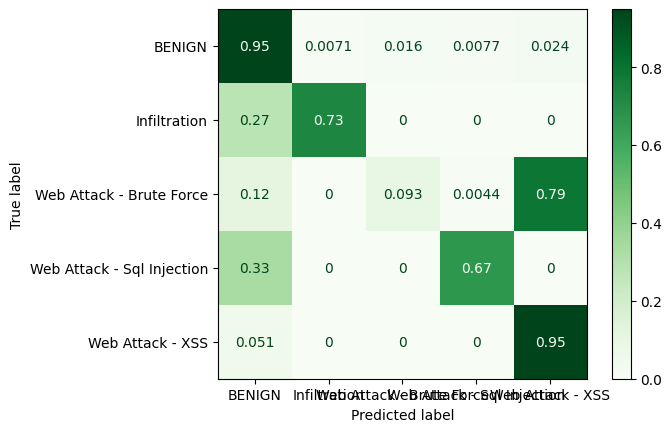

In [36]:
# Cell 16

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(lr, X_test, y_test, cmap='Greens', normalize='true')
                                      

## Interpretation

In both models, the confusion matrices show that 91% of low-readiness facilities were correctly identified as low (true negatives), and 87% of moderate/high-readiness facilities were correctly identified as such (true positives). These figures correspond to the recall for each class, suggesting that the models are effective at minimizing both false alarms (false positives) and missed high-readiness cases (false negatives). The remaining 9% and 13% represent the respective error rates in each category.

# Logistic Regression
As a linear model, Logistic Regression provides interpretable coefficients, which can be mapped to the theoretical constructs of Protection Motivation Theory (e.g., the positive influence of response efficacy or training frequency on readiness classification).

# Random Forest
The Random Forest model, on the other hand, leverages non-linear decision boundaries and feature interactions. It additionally provides a ranked measure of feature importance, offering insights into which organizational, behavioral, and technical variables most influence cybersecurity readiness.

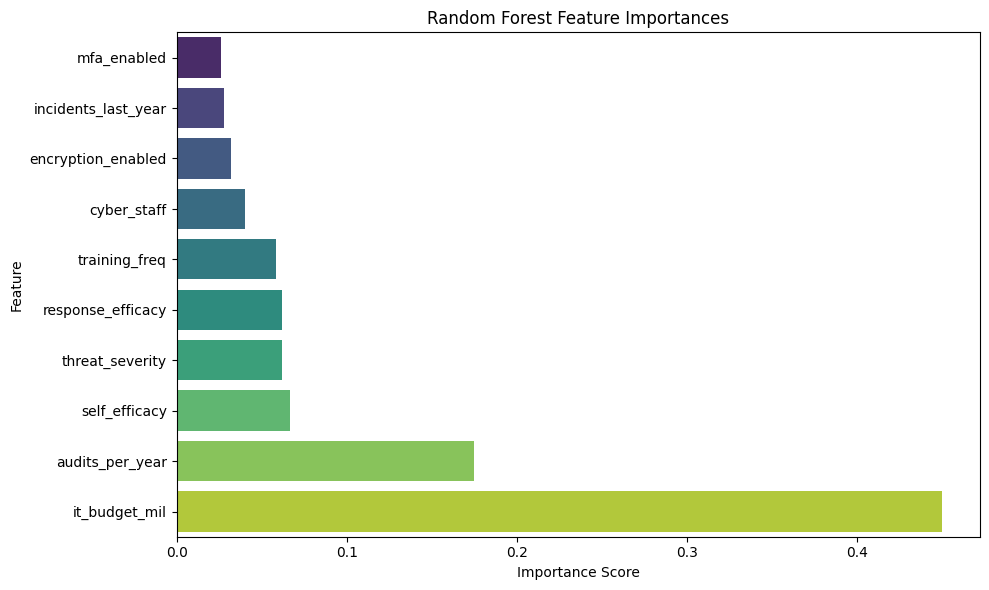

In [37]:
# Cell 17

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Reload the data and continue with feature importance analysis
# Reload the dataset
df = pd.read_csv(r"C:\Users\Owner\OneDrive\Documents\synthetic_cyber_readiness.csv")

# Prepare binary target
df['readiness_binary'] = df['readiness_level'].replace({2: 1})

# Split features and target
X = df.drop(columns=['facility_id', 'readiness_level', 'readiness_binary'])
y = df['readiness_binary']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

# Train Random Forest model
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Extract feature importances
importances = rf.feature_importances_
feature_names = X.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=forest_importances, y=forest_importances.index, palette='viridis')
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Interpretation of Random Forest Model

The Random Forest model identified several key predictors that significantly influenced the classification of a healthcare facility's cybersecurity readiness. Among these, overall IT budget (in millions of dollars) emerged as the most influential variable. This suggests that higher levels of organizational investment in IT infrastructure, personnel, and security tools directly support a more robust cybersecurity posture. Financial resources likely facilitate not only the acquisition of technical controls but also the capacity for more comprehensive training, monitoring, and response capabilities.

The second most important feature was the frequency of system audits conducted per year. This variable serves as a proxy for procedural oversight and governance. Frequent audits are associated with improved detection of vulnerabilities, validation of policy adherence, and routine system checks that enable organizations to proactively identify and respond to risks. This aligns with best practices in risk management, where periodic audits function as a critical control to ensure the integrity and resilience of digital infrastructure.

The third-highest contributor was self-efficacy, defined in the context of Protection Motivation Theory as the perceived ability of staff—particularly IT professionals and cybersecurity personnel—to carry out protective behaviors effectively. High self-efficacy reflects confidence in executing incident response protocols, detecting threats, and mitigating attacks. This behavioral component reinforces the theoretical foundation of the study, highlighting the role of human belief systems and perceived competence in shaping the success of technical and organizational security strategies.

Together, these features reflect the intersection of organizational capacity, operational discipline, and behavioral readiness. The model’s output supports the argument that cybersecurity readiness is not solely dependent on technical solutions, but rather on a broader ecosystem of resourcing, routine practice, and human capability.

## SHAP ANALYSIS: Interpreting Individual Feature Contributions

C:\Users\Owner\AppData\Local\Temp\ipykernel_18620\1254119216.py:10: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'bool'):


<Figure size 640x480 with 0 Axes>

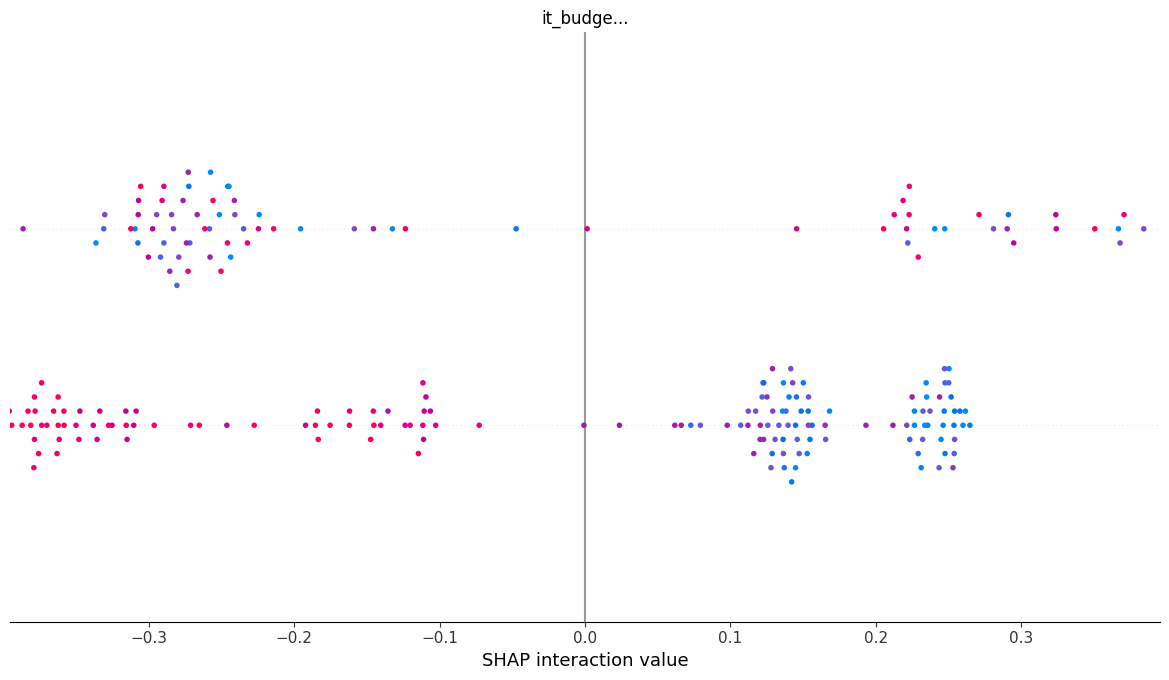

In [38]:
# Cell 18

# 1. Install SHAP (run only once)
!pip install shap

# 2. Imports
import shap
import numpy as np
import pandas as pd

# 3. Handle SHAP compatibility with NumPy (in case of deprecation errors)
if not hasattr(np, 'bool'):
    np.bool = bool

# 4. Create SHAP explainer
explainer = shap.Explainer(rf, X_train)  # replace 'rf' with your trained model

# 5. Calculate SHAP values
shap_values = explainer(X_train, check_additivity=False)

# 6. Bar plot: global feature importance
shap.summary_plot(shap_values.values, X_train, plot_type="bar")

In [39]:
# Cell 19

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Create the base model
rf = RandomForestClassifier(random_state=42)

# Set up the grid search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='f1_macro')  # You can change scoring if desired

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_
print("Best Parameters:\n", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters:
 {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 50}


In [40]:
# Cell 20

best_rf = grid_search.best_estimator_

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        35
           1       0.93      0.87      0.90        15

    accuracy                           0.94        50
   macro avg       0.94      0.92      0.93        50
weighted avg       0.94      0.94      0.94        50



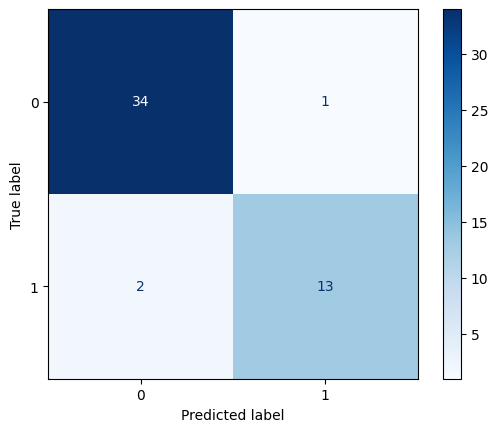

In [41]:
# Cell 21

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test, cmap='Blues')

<Figure size 640x480 with 0 Axes>

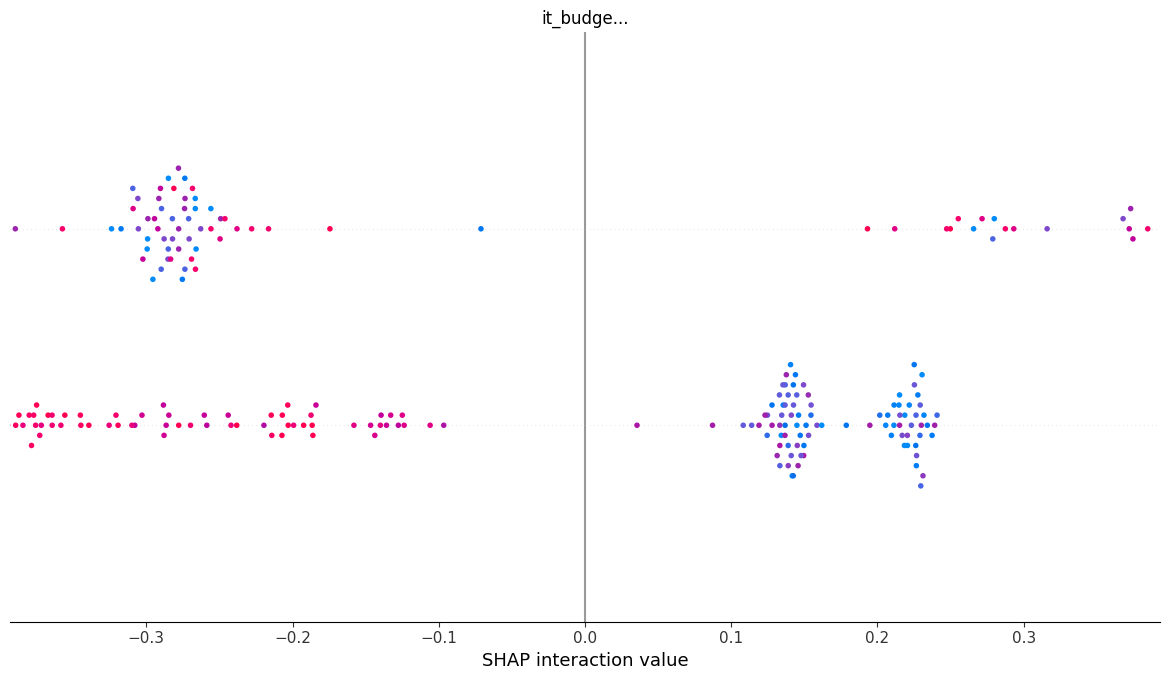

In [42]:
# Cell 22

explainer = shap.Explainer(best_rf, X_train)

# Added check_additivity=False parameter
shap_values = explainer(X_train, check_additivity=False) 
shap.summary_plot(shap_values, X_train)

## SHAP Beeswarm Plot- Feature Interaction for it_budget_mil

This visualization shows the distribution of SHAP interaction values for the it_budget_mil feature. Higher IT budgets (represented in red, right-hand side) contribute strongly to the model predicting positive outcomes (e.g., proactive cybersecurity behavior), whereas lower budgets (in blue, left-hand side) pull the prediction toward the negative class. This confirms the intuitive relationship between financial resources and proactive cybersecurity postures, as reinforced by Protection Motivation Theory (PMT) coping appraisals.
The model recognizes it_budget_mil as the most influential predictor based on SHAP value magnitude.

In [ ]:

# [Feature Importance] Random Forest — Top 15
import numpy as np
import matplotlib.pyplot as plt

try:
    rf  # check model exists
except NameError:
    print("RandomForest model 'rf' not found. Train RF before running this cell.")
else:
    # Try to recover feature names
    feature_names = None
    try:
        # If RF was fit on a pandas DataFrame, scikit-learn tracks names here
        feature_names = getattr(rf, "feature_names_in_", None)
    except Exception:
        feature_names = None

    # Fallback: if you've kept the original X as a DataFrame, try to use its columns
    if feature_names is None:
        try:
            feature_names = X.columns
        except Exception:
            feature_names = None

    importances = getattr(rf, "feature_importances_", None)
    if importances is None:
        print("RandomForestClassifier has no 'feature_importances_' attribute (was it fitted?).")
    else:
        idx = np.argsort(importances)[-15:][::-1]
        labels = [str(i) for i in idx] if feature_names is None else np.array(feature_names)[idx]

        plt.figure(figsize=(8, 4))
        plt.bar(range(len(idx)), importances[idx])
        plt.xticks(range(len(idx)), labels, rotation=45, ha='right')
        plt.title('Random Forest — Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()


In [ ]:

# [Confusion Matrices] Logistic Regression, Random Forest, XGBoost
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

models = []
try:
    lr
    models.append(("LogReg", lr))
except NameError:
    print("Note: 'lr' (Logistic Regression) not found; skipping.")
try:
    rf
    models.append(("RandomForest", rf))
except NameError:
    print("Note: 'rf' (Random Forest) not found; skipping.")
try:
    xgb
    models.append(("XGBoost", xgb))
except NameError:
    print("Note: 'xgb' (XGBoost) not found; skipping.")

if not models:
    print("No models to plot. Train your models before running this cell.")
else:
    for name, est in models:
        ConfusionMatrixDisplay.from_estimator(est, X_test, y_test, cmap='Blues', normalize='true')
        plt.title(f'{name} — Normalized Confusion Matrix')
        plt.show()
